In [1]:
# Add libraries
library(tidyverse)
library(repr)
library(digest)
library(infer)
library(gridExtra)
library(cowplot)
library(dplyr)
library(broom)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [2]:
# Read data from .csv file
survey <- read.csv('survey lung cancer.csv')
head(survey)

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC.DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL.CONSUMING,COUGHING,SHORTNESS.OF.BREATH,SWALLOWING.DIFFICULTY,CHEST.PAIN,LUNG_CANCER
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
1,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
2,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
3,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
4,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
5,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO
6,F,75,1,2,1,1,2,2,2,2,1,2,2,1,1,YES


In [3]:
# Change most of the variables to boolean variables instead of integer or string variables
survey_2 <- survey %>%
    summarize(gender = GENDER,
              age = AGE,
              smoking = SMOKING - 1 == 1,
              yellow_fingers = YELLOW_FINGERS - 1 == 1,
              anxiety = ANXIETY - 1 == 1,
              chronic_disease = CHRONIC.DISEASE - 1 == 1,
              fatigue = FATIGUE - 1 == 1,
              allergy = ALLERGY - 1 == 1,
              wheezing = WHEEZING - 1 == 1,
              alcohol_consuming = ALCOHOL.CONSUMING - 1 == 1,
              coughing = COUGHING - 1 == 1,
              shortness_of_breath = SHORTNESS.OF.BREATH - 1 == 1,
              swallowing_difficulty = SWALLOWING.DIFFICULTY - 1 == 1,
              chest_pain = CHEST.PAIN - 1 == 1,
              lung_cancer = LUNG_CANCER == "YES")

head(survey_2)

,gender,age,smoking,yellow_fingers,anxiety,chronic_disease,fatigue,allergy,wheezing,alcohol_consuming,coughing,shortness_of_breath,swallowing_difficulty,chest_pain,lung_cancer
,<chr>,<int>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
1,M,69,FALSE,TRUE,TRUE,FALSE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
2,M,74,TRUE,FALSE,FALSE,TRUE,TRUE,TRUE,FALSE,FALSE,FALSE,TRUE,TRUE,TRUE,TRUE
3,F,59,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE,FALSE,TRUE,TRUE,FALSE,TRUE,FALSE
4,M,63,TRUE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,TRUE,TRUE,FALSE
5,F,63,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE
6,F,75,FALSE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,FALSE,TRUE


In [4]:
# Clean and wrangle data; we are only interested in people who have lung cancer and whether or not they smoked and/or consumed alcohol
# We mutate the data this way to properly separate all combinations of smoking and drinking
# We want the difference in proportions for only smoking minus only drinking
survey_clean_wrangled <- survey_2 %>%
    filter(lung_cancer == TRUE) %>%
    select(gender, smoking, alcohol_consuming) %>%
    mutate(none = !smoking & !alcohol_consuming,
           only_smoking = smoking & !alcohol_consuming,
           only_drinking = !smoking & alcohol_consuming,
           both = smoking & alcohol_consuming) %>%
    select(-alcohol_consuming, -smoking)

head(survey_clean_wrangled)

,gender,none,only_smoking,only_drinking,both
,<chr>,<lgl>,<lgl>,<lgl>,<lgl>
1,M,FALSE,FALSE,TRUE,FALSE
2,M,FALSE,TRUE,FALSE,FALSE
3,F,TRUE,FALSE,FALSE,FALSE
4,M,FALSE,FALSE,FALSE,TRUE
5,F,FALSE,TRUE,FALSE,FALSE
6,M,FALSE,FALSE,FALSE,TRUE


In [5]:
# Separate the genders; the processes for the female data will be displayed above the processes for the male data
survey_female <- survey_clean_wrangled %>%
    filter(gender == "F") %>%
    select(-gender)

survey_male <- survey_clean_wrangled %>%
    filter(gender == "M") %>%
    select(-gender)

# Create bootstrap distributions using the clean and wrangled data
set.seed(1)
bootstrap_survey_female <- survey_female %>%
    rep_sample_n(size = nrow(survey_female), reps = 1000, replace = TRUE)

set.seed(1)
bootstrap_survey_male <- survey_male %>%
    rep_sample_n(size = nrow(survey_male), reps = 1000, replace = TRUE)


head(bootstrap_survey_female)
head(bootstrap_survey_male)

replicate,none,only_smoking,only_drinking,both
<int>,<lgl>,<lgl>,<lgl>,<lgl>
1,FALSE,FALSE,FALSE,TRUE
1,FALSE,FALSE,TRUE,FALSE
1,FALSE,TRUE,FALSE,FALSE
1,TRUE,FALSE,FALSE,FALSE
1,FALSE,FALSE,TRUE,FALSE
1,FALSE,FALSE,TRUE,FALSE


replicate,none,only_smoking,only_drinking,both
<int>,<lgl>,<lgl>,<lgl>,<lgl>
1,FALSE,FALSE,TRUE,FALSE
1,FALSE,FALSE,FALSE,TRUE
1,TRUE,FALSE,FALSE,FALSE
1,FALSE,TRUE,FALSE,FALSE
1,FALSE,FALSE,TRUE,FALSE
1,FALSE,FALSE,FALSE,TRUE


In [6]:
# Calculate the number of and proportion of only smokers and only drinkers for each replicate
# After calculating the proportions, calculate the difference in proportions
bootstrap_survey_female_summary <- bootstrap_survey_female %>%
    group_by(replicate) %>%
    summarize(num_only_smoking = sum(only_smoking),
              num_only_drinking = sum(only_drinking),
              prop_only_smoking = mean(only_smoking),
              prop_only_drinking = mean(only_drinking),
              diff_in_props = prop_only_smoking - prop_only_drinking)

bootstrap_survey_male_summary <- bootstrap_survey_male %>%
    group_by(replicate) %>%
    summarize(num_only_smoking = sum(only_smoking),
              num_only_drinking = sum(only_drinking),
              prop_only_smoking = mean(only_smoking),
              prop_only_drinking = mean(only_drinking),
              diff_in_props = prop_only_smoking - prop_only_drinking)

head(bootstrap_survey_female_summary)
head(bootstrap_survey_male_summary)

replicate,num_only_smoking,num_only_drinking,prop_only_smoking,prop_only_drinking,diff_in_props
<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,44,22,0.352,0.176,0.176
2,53,24,0.424,0.192,0.232
3,61,24,0.488,0.192,0.296
4,49,29,0.392,0.232,0.160
5,54,27,0.432,0.216,0.216
6,60,19,0.480,0.152,0.328


replicate,num_only_smoking,num_only_drinking,prop_only_smoking,prop_only_drinking,diff_in_props
<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,16,50,0.11034483,0.3448276,-0.2344828
2,14,53,0.09655172,0.3655172,-0.2689655
3,16,46,0.11034483,0.3172414,-0.2068966
4,12,49,0.08275862,0.3379310,-0.2551724
5,12,41,0.08275862,0.2827586,-0.2000000
6,20,48,0.13793103,0.3310345,-0.1931034


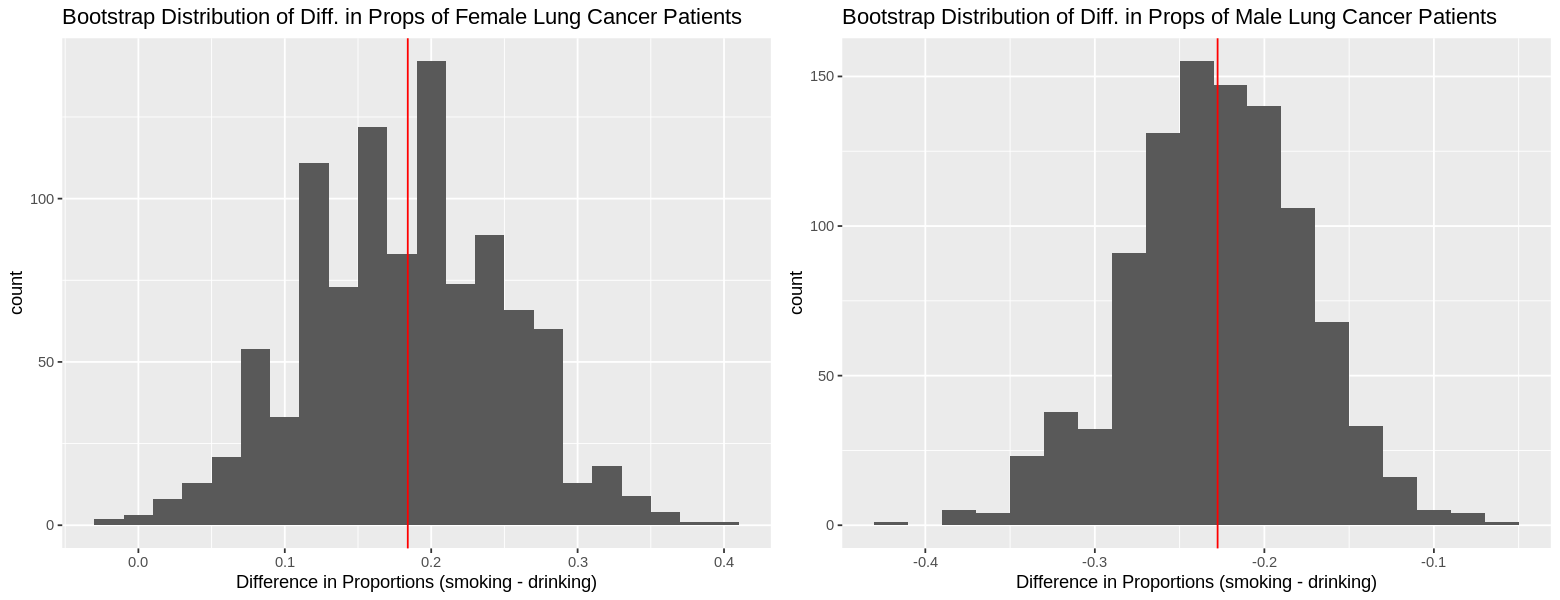

In [7]:
# Increase the size of future plots
options(repr.plot.width = 13, repr.plot.height = 5)

# Find the sample prop. of smoking only - the prop. of drinking only for female lung cancer patients
sample_diff_in_props_female <- survey_clean_wrangled %>%
    filter(gender == "F") %>%
    select(-gender) %>%
    summarize(prop_only_smoking = mean(only_smoking),
              prop_only_drinking = mean(only_drinking),
              diff_in_props = prop_only_smoking - prop_only_drinking) %>%
    select(diff_in_props) %>%
    pull()

# Plot the bootstrap distribution of smoking only - drinking only for female lung cancer patients;
# the red line shows the sample prop. of smoking only - the prop. of drinking only
bootstrap_distribution_female <- bootstrap_survey_female_summary %>%
    ggplot(aes(x = diff_in_props)) +
        geom_histogram(binwidth = 0.02) +
        geom_vline(xintercept = sample_diff_in_props_female, color = "red") +
        labs(x = "Difference in Proportions (smoking - drinking)") +
        ggtitle("Bootstrap Distribution of Diff. in Props of Female Lung Cancer Patients")

# Find the sample prop. of smoking only - the prop. of drinking only for male lung cancer patients
sample_diff_in_props_male <- survey_clean_wrangled %>%
    filter(gender == "M") %>%
    select(-gender) %>%
    summarize(prop_only_smoking = mean(only_smoking),
              prop_only_drinking = mean(only_drinking),
              diff_in_props = prop_only_smoking - prop_only_drinking) %>%
    select(diff_in_props) %>%
    pull()

# Plot the bootstrap distribution of the prop. of smoking only - the prop. of drinking only for male lung cancer patients;
# the red line shows the sample prop. of smoking only - the prop. of drinking only
bootstrap_distribution_male <- bootstrap_survey_male_summary %>%
    ggplot(aes(x = diff_in_props)) +
        geom_histogram(binwidth = 0.02) +
        geom_vline(xintercept = sample_diff_in_props_male, color = "red") +
        labs(x = "Difference in Proportions (smoking - drinking)") +
        ggtitle("Bootstrap Distribution of Diff. in Props of Male Lung Cancer Patients")

# Display plots above
grid.arrange(bootstrap_distribution_female,
             bootstrap_distribution_male,
             ncol = 2)

In [8]:
# Set type I error to 5%, can be changed
alpha = 0.05

In [9]:
# Calculate p-hat and z-score using worksheet 8 section 3.4, then calculate p-value and check if p-value < alpha
bootstrap_survey_female_calcs <- bootstrap_survey_female_summary %>%
    mutate(lower_ci = diff_in_props - qnorm(alpha / 2, lower.tail = FALSE) * sqrt(prop_only_smoking ^ 2 + prop_only_drinking ^ 2),
           upper_ci = diff_in_props + qnorm(alpha / 2, lower.tail = FALSE) * sqrt(prop_only_smoking ^ 2 + prop_only_drinking ^ 2),
           captured = lower_ci <= sample_diff_in_props_male & sample_diff_in_props_male <= upper_ci,
           p_hat = (num_only_smoking * prop_only_smoking + num_only_drinking * prop_only_drinking) / (num_only_smoking + num_only_drinking),
           z_score = diff_in_props / sqrt(p_hat * (1 - p_hat) * (1 / num_only_smoking + 1 / num_only_drinking)),
           p_value = pnorm(z_score, lower.tail = FALSE),
           reject_null = p_value < alpha)

bootstrap_survey_male_calcs <- bootstrap_survey_male_summary %>%
    mutate(lower_ci = diff_in_props - qnorm(alpha / 2, lower.tail = FALSE) * sqrt(prop_only_smoking ^ 2 + prop_only_drinking ^ 2),
           upper_ci = diff_in_props + qnorm(alpha / 2, lower.tail = FALSE) * sqrt(prop_only_smoking ^ 2 + prop_only_drinking ^ 2),
           captured = lower_ci <= sample_diff_in_props_male & sample_diff_in_props_male <= upper_ci,
           p_hat = (num_only_smoking * prop_only_smoking + num_only_drinking * prop_only_drinking) / (num_only_smoking + num_only_drinking),
           z_score = diff_in_props / sqrt(p_hat * (1 - p_hat) * (1 / num_only_smoking + 1 / num_only_drinking)),
           p_value = pnorm(z_score, lower.tail = FALSE),
           reject_null = p_value < alpha)

head(bootstrap_survey_female_calcs)
head(bootstrap_survey_male_calcs)

replicate,num_only_smoking,num_only_drinking,prop_only_smoking,prop_only_drinking,diff_in_props,lower_ci,upper_ci,captured,p_hat,z_score,p_value,reject_null
<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<lgl>
1,44,22,0.352,0.176,0.176,-0.5953398,0.9473398,TRUE,0.2933333,1.480438,0.06937813,FALSE
2,53,24,0.424,0.192,0.232,-0.6802574,1.1442574,TRUE,0.3516883,1.974764,0.02414745,TRUE
3,61,24,0.488,0.192,0.296,-0.7318287,1.3238287,TRUE,0.4044235,2.503029,0.00615678,TRUE
4,49,29,0.392,0.232,0.160,-0.7327803,1.0527803,TRUE,0.3325128,1.449586,0.07358697,FALSE
5,54,27,0.432,0.216,0.216,-0.7306443,1.1626443,TRUE,0.3600000,1.909188,0.02811890,TRUE
6,60,19,0.480,0.152,0.328,-0.6588258,1.3148258,TRUE,0.4011139,2.542183,0.00550813,TRUE


replicate,num_only_smoking,num_only_drinking,prop_only_smoking,prop_only_drinking,diff_in_props,lower_ci,upper_ci,captured,p_hat,z_score,p_value,reject_null
<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<lgl>
1,16,50,0.11034483,0.3448276,-0.2344828,-0.9440927,0.4751272,TRUE,0.2879833,-1.802832,0.9642927,FALSE
2,14,53,0.09655172,0.3655172,-0.2689655,-1.0099384,0.4720074,TRUE,0.3093155,-1.936513,0.9735976,FALSE
3,16,46,0.11034483,0.3172414,-0.2068966,-0.8652171,0.4514240,TRUE,0.2638487,-1.617466,0.9471112,FALSE
4,12,49,0.08275862,0.3379310,-0.2551724,-0.9370776,0.4267328,TRUE,0.2877332,-1.750012,0.9599419,FALSE
5,12,41,0.08275862,0.2827586,-0.2000000,-0.7774462,0.3774462,TRUE,0.2374756,-1.431984,0.9239258,FALSE
6,20,48,0.13793103,0.3310345,-0.1931034,-0.8959871,0.5097802,TRUE,0.2742394,-1.626333,0.9480606,FALSE


In [10]:
probability_reject_null_female <- mean(bootstrap_survey_female_calcs$reject_null)
probability_reject_null_male <- mean(bootstrap_survey_male_calcs$reject_null)

probability_reject_null_female
probability_reject_null_male

[1] 0.493

[1] 0

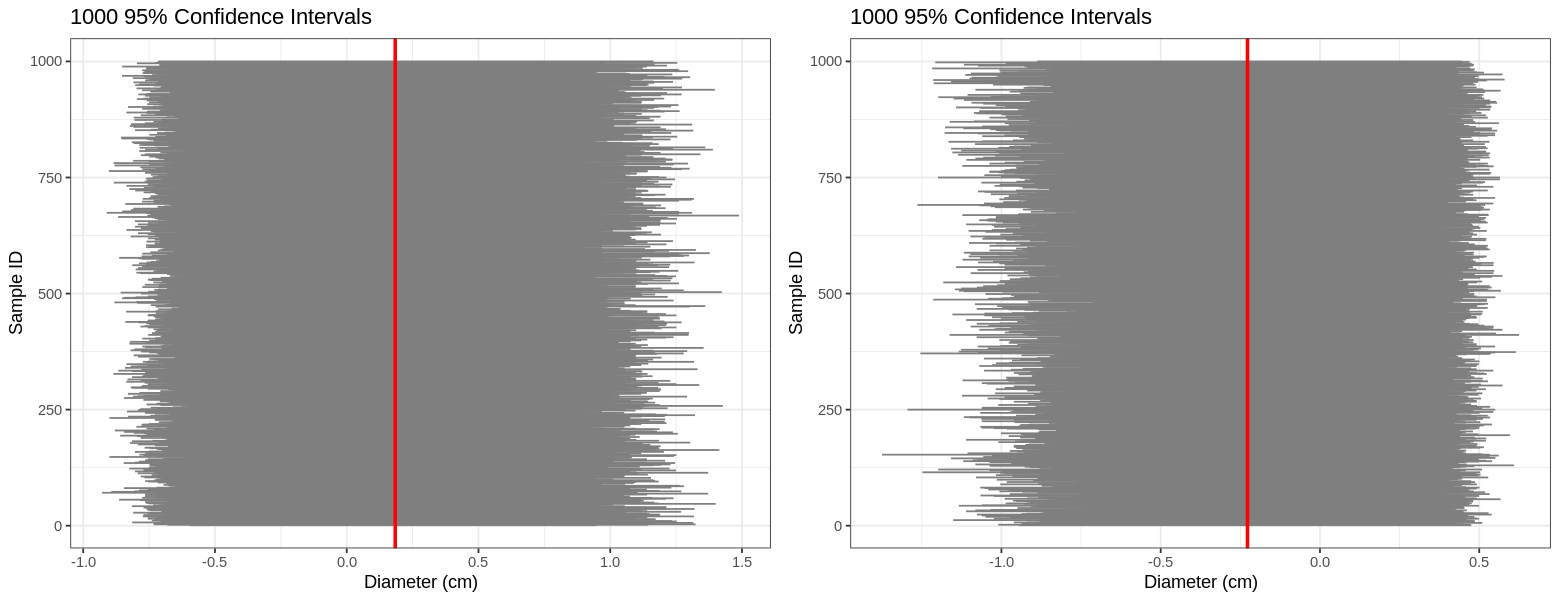

In [11]:
options(repr.plot.width = 13, repr.plot.height = 5)

many_ci_plot_female <- bootstrap_survey_female_calcs %>%
    ggplot() +
    scale_colour_manual(breaks = c("TRUE", "FALSE"), # Change colour scale for better visibility.
                        values = c("grey", "black")) +
    geom_segment(aes(x = lower_ci,
                     xend = upper_ci,
                     y = replicate,
                     yend = replicate,
                     colour = "blue")) +
    geom_vline(xintercept = sample_diff_in_props_female, colour = "red", size = 1) +
    labs(title = "1000 95% Confidence Intervals",
         y = "Sample ID",
         x = "Diameter (cm)",
         colour = "Captured?") +
    theme_bw() # Sets a theme for better visibility.

many_ci_plot_male <- bootstrap_survey_male_calcs %>%
    ggplot() +
    scale_colour_manual(breaks = c("TRUE", "FALSE"), # Change colour scale for better visibility.
                        values = c("grey", "black")) +
    geom_segment(aes(x = lower_ci,
                     xend = upper_ci,
                     y = replicate,
                     yend = replicate,
                     colour = "blue")) +
    geom_vline(xintercept = sample_diff_in_props_male, colour = "red", size = 1) +
    labs(title = "1000 95% Confidence Intervals",
         y = "Sample ID",
         x = "Diameter (cm)",
         colour = "Captured?") +
    theme_bw() # Sets a theme for better visibility.

# Display plots above
grid.arrange(many_ci_plot_female,
             many_ci_plot_male,
             ncol = 2)